# 🌲 Train Random Forest on Drug Response with scFoundation Embeddings

This notebook trains a Random Forest regressor per drug using scFoundation-derived PCA features and evaluates the model via cross-validation.


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


## 📥 Configuration and Dataset Loading


In [2]:
NUM_PCS = 30  # or whatever number you selected
DATA_PATH = f"../../data/bulk/bulk_with_scfoundation_pca_top{NUM_PCS}.parquet"

data = pd.read_parquet(DATA_PATH)
print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 53)


In [3]:
os.makedirs("results/random_forest", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
feature_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


## 🔁 Train Random Forest Regressor per Drug with Cross-Validation


In [4]:
results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        continue

    X = df[feature_cols].values
    y = df["LN_IC50"].values

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X, y)

    rmse_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring="r2", cv=kf)

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })


## 💾 Save and Preview Results


In [5]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"results/random_forest/rf_results_{NUM_PCS}_pcs.csv", index=False)

print(f"📁 Saved to results/random_forest/rf_results_{NUM_PCS}_pcs.csv")
results_df.head()


📁 Saved to results/random_forest/rf_results_30_pcs.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.101261,0.173297,-0.017967,0.127705
1,3,356,2.017757,0.221730,-0.032593,0.060543
2,5,394,1.480823,0.078258,0.188997,0.051242
3,6,403,0.902200,0.080151,-0.041911,0.049247
4,9,396,1.387774,0.131095,0.086599,0.071537


## 📊 Visualize Performance Across Drugs


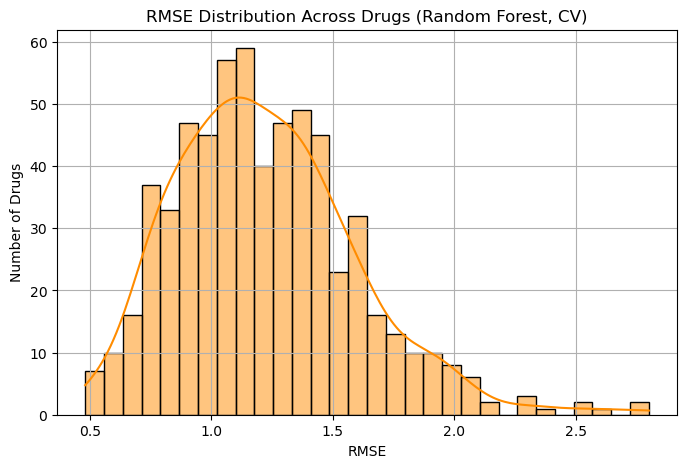

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (Random Forest, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/random_forest/rf_rmse_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()


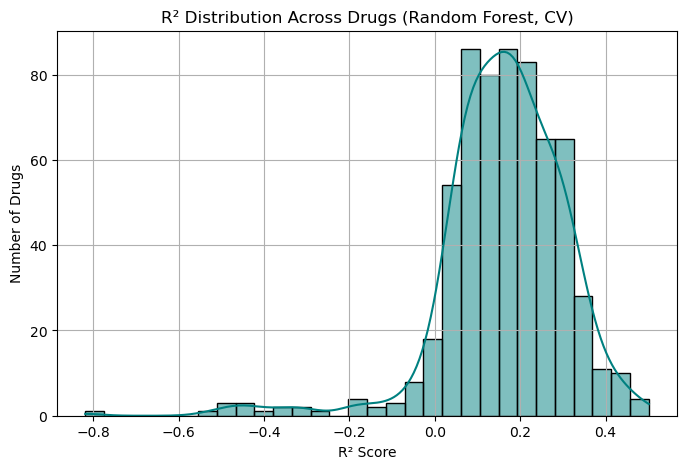

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (Random Forest, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/random_forest/rf_r2_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()
